# NYC Subway Elevators and Escalators: Monthly Failure-Risk Classifier for a More Accessible Network





## Step 1. Overview

**1.1 Bottom Line Up Front:**
This project analyzes elevator reliability across the NYC subway system to predict high-risk months before failures occur. We used a blended machine learning model to flag units with likely unscheduled outages or entrapments, enabling more proactive maintenance and safer, more accessible travel for ADA-reliant riders.

**1.2 Key Results:**
* Our blended ensemble achieved a recall of 0.9885, meaning we catch nearly all upcoming failures with very low false negatives.

* F1 score of 0.7300 shows solid balance: among flagged elevator-months, over half turned out to be true failures.

* AUROC = 0.7680 confirms strong risk ranking ability, enabling targeted maintenance.

* The top 10% riskiest elevator-months accounted for a disproportionate share of system-wide outages.

**1.3 Dataset Overview:**

* Scope: Jan 2015 – May 2025 (125 months)

* Records: 72,797 elevator-months

* Assets: 673 elevators at 174 stations (4 boroughs)

* Key variables: Unscheduled/Scheduled outage hours, Entrapments, Availability %, Repair time, Improvement history

* Label: Failure = ≥2 unscheduled outages OR ≥1 entrapment in a month

* Citations: MTA Open Data [MTA NYCT Subway Elevator and Escalator Availability: Beginning 2015
](https://data.ny.gov/Transportation/MTA-NYCT-Subway-Elevator-and-Escalator-Availabilit/rc78-7x78/about_data)

## Step 2. Library Loading and Quick EDA on Raw Data

###2.1 Load data and libraries

Filted to only elevator data here! (Remove escalators)



In [31]:
#upload file from google drieve
from google.colab import files
uploaded = files.upload()

Saving MTA_NYCT_Subway_Elevator_and_Escalator_Availability__Beginning_2015.csv to MTA_NYCT_Subway_Elevator_and_Escalator_Availability__Beginning_2015 (1).csv


In [32]:
# Data handling
import pandas as pd
import numpy as np

# Date/time utilities
from datetime import datetime as dt
import dateutil         # for parsing dates, building cyclic month features

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns            # heatmaps, distributions
import missingno as msno         # missing‐value matrix/heatmap

# Preprocessing & pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature engineering helpers
import scipy.stats as stats       # z‐score, Box–Cox, etc.

# Model selection & metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report
)

# Supervised models/ Unsupervised / clustering / Dimensionality reduction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Hyperparameter Tuning and Cross Validation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

# Deep learning (stretch goal)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Explainability
import shap              # SHAP value plots

# Utilities
import joblib            # save/load models
import json, yaml        # config management

In [33]:
#load dataset as df - re-run this when trying to refresh dataset so we don't need to load the entire set again
df = pd.read_csv('MTA_NYCT_Subway_Elevator_and_Escalator_Availability__Beginning_2015.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72797 entries, 0 to 72796
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Month                         72797 non-null  object 
 1   Borough                       72797 non-null  object 
 2   Equipment Type                72797 non-null  object 
 3   Equipment Code                72797 non-null  object 
 4   Total Outages                 72797 non-null  int64  
 5   Scheduled Outages             72797 non-null  int64  
 6   Unscheduled Outages           72797 non-null  int64  
 7   Entrapments                   72797 non-null  int64  
 8   Time Since Major Improvement  61620 non-null  float64
 9   AM Peak Availability          70805 non-null  float64
 10  AM Peak Hours Available       72797 non-null  float64
 11  AM Peak Total Hours           72797 non-null  float64
 12  PM Peak Availability          70819 non-null  float64
 13  P

In [34]:
# keep only elevator records
df = df[df['Equipment Type'].str.lower() == 'elevator'].copy()

### 2.2 Basic EDA

In [35]:
#inspection
print(df.columns.tolist())
df.head()

['Month', 'Borough', 'Equipment Type', 'Equipment Code', 'Total Outages', 'Scheduled Outages', 'Unscheduled Outages', 'Entrapments', 'Time Since Major Improvement', 'AM Peak Availability', 'AM Peak Hours Available', 'AM Peak Total Hours', 'PM Peak Availability', 'PM Peak Hours Available', 'PM Peak Total Hours', '24-Hour Availability', '24-Hour Hours Available', '24-Hour Total Hours', 'Station Name', 'Station MRN', 'Station Complex Name', 'Station Complex MRN']


,Month,Borough,Equipment Type,Equipment Code,Total Outages,Scheduled Outages,Unscheduled Outages,Entrapments,Time Since Major Improvement,AM Peak Availability,...,PM Peak Availability,PM Peak Hours Available,PM Peak Total Hours,24-Hour Availability,24-Hour Hours Available,24-Hour Total Hours,Station Name,Station MRN,Station Complex Name,Station Complex MRN
0,01/01/2015,Queens,Elevator,EL426,2,2,0,0,95.0,1.000000,...,1.000000,124.000000,124.0,0.986022,733.600000,744.0,JUNCTIONBLVD-FLS-7,451,Junction Blvd - Station,451
1,01/01/2015,Queens,Elevator,EL411,6,5,1,0,313.0,0.984677,...,0.981586,121.716667,124.0,0.962522,716.116667,744.0,SUTPHINBLVD-ARCHERAV-JFKAIRPORT-QBL-E/J/Z,279,Sutphin Blvd-Archer Av-JFK Airport - Station,279
3,01/01/2015,Queens,Elevator,EL449X,0,0,0,0,NaN,1.000000,...,1.000000,124.000000,124.0,1.000000,744.000000,744.0,SUTPHINBLVD-ARCHERAV-JFKAIRPORT-QBL-E/J/Z,279,Sutphin Blvd-Archer Av-JFK Airport - Station,279
5,01/01/2015,Brooklyn,Elevator,EL706,13,3,10,4,56.0,0.438978,...,0.325269,40.333333,124.0,0.375045,279.033333,744.0,JAYST-METROTECH-8AV-A/C/F,174,"Jay St-MetroTech (A,C,F,R)",636
6,01/01/2015,Manhattan,Elevator,EL244,2,2,0,0,157.0,1.000000,...,1.000000,124.000000,124.0,0.992787,738.633333,744.0,GRANDCENTRAL-42ST-FLS-7,465,"Grand Central-42 St (S,4,5,6,7)",610


#### Key Variable distribution (Outages, entrapments, time seince major improvement)

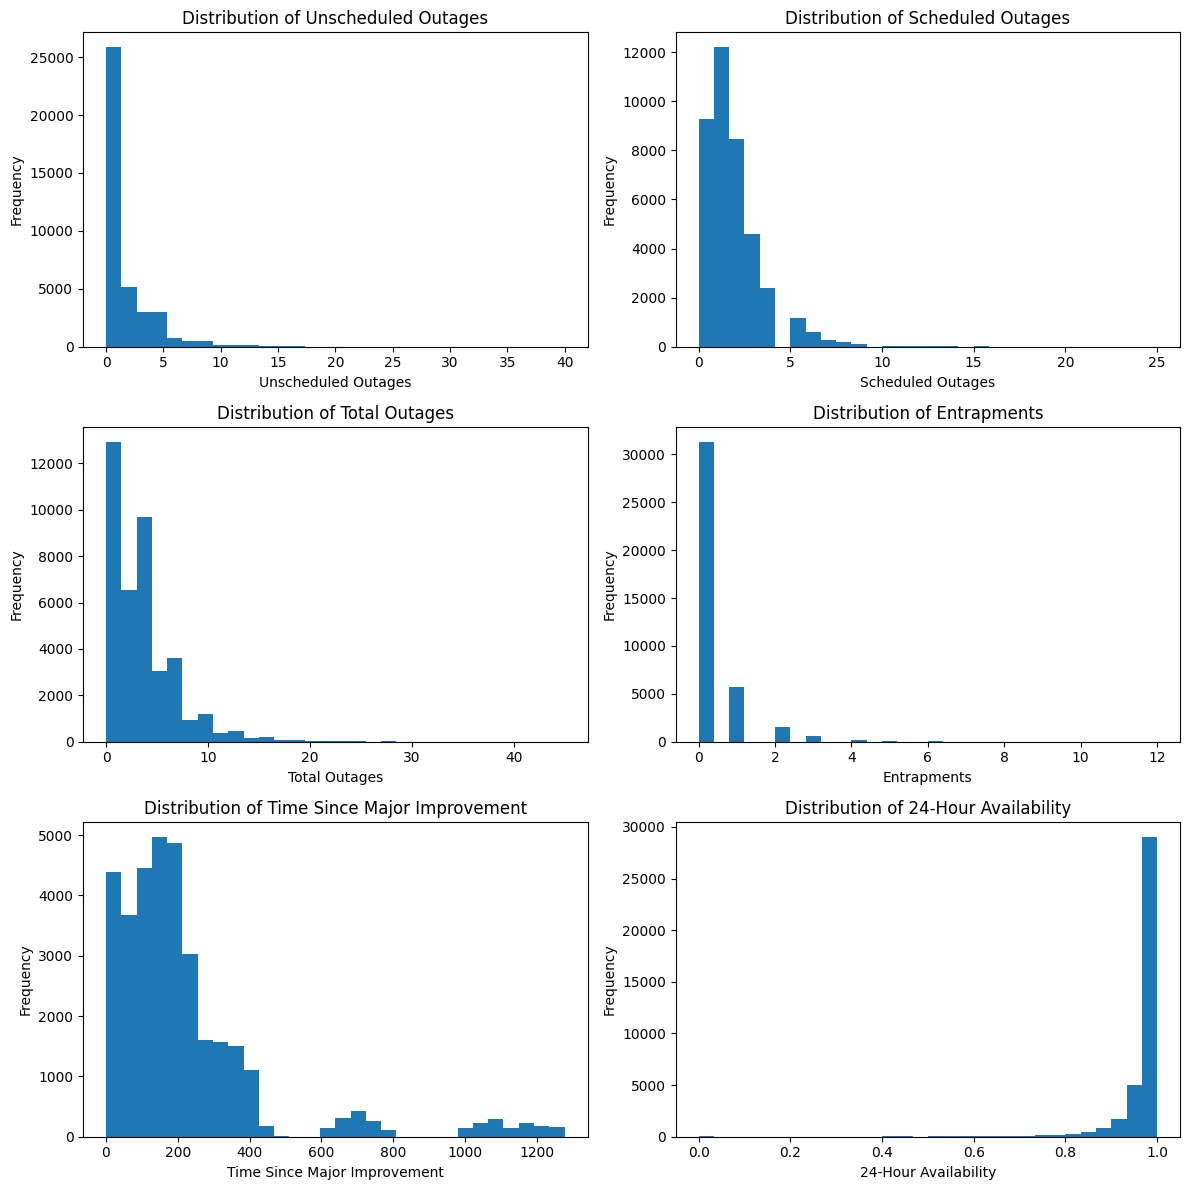

In [36]:
#key variable distributions

#parse month as datetime and set as index:
df['Month'] = pd.to_datetime(df['Month'], format='%m/%d/%Y')
df.set_index('Month', inplace=True)

#define key variables
key_vars = [
    'Unscheduled Outages',
    'Scheduled Outages',
    'Total Outages',
    'Entrapments',
    'Time Since Major Improvement',
    '24-Hour Availability'
]

# Create a 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each distribution in its subplot
for ax, var in zip(axes, key_vars):
    ax.hist(df[var].dropna(), bins=30)
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Hide any unused subplots (if key_vars < total axes)
for i in range(len(key_vars), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

##### Key takeaways from distribution plots:

- **Variable Distributions**
    - **Unscheduled Outages**: Right-skewed event counts—25 % of months have 0 events, median = 1 event, max = 40 events
        - Most months see 0–2 outage events, but occasional spikes up to 40 -> use a robust scaler and capture tail events.
    - **Scheduled Outages**: *Shape & Key Stats:* Right-skewed—median = 1 event, max = 25 events
        - Regular maintenance events are frequent but small -> treat similarly to unscheduled outages in preprocessing.
    - **Total Outages**: Shape & Key Stats:* Median = 3 events, max = 45 events
        - Combines both event types; binary “will-fail” label will be heavily imbalanced toward “no.”
    - **Entrapments**: 75 % of months have 0 incidents, max = 12 incidents
        - Rare but safety-critical; might need SMOTE or an anomaly-detection approach for modeling.
    - **Time Since Major Improvement**: Days since last rehab—25 % ≤ 90 days, median ≈ 166 days, max ≈ 1 276 days; ~14 % missing
        - Bucket into ranges (e.g., ≤ 6 mo, 6–12 mo, > 12 mo), and impute missing values.
        - Note: The dataset website noted that "Time Since Major Improvement" stands for "Months since last improvement" - but seeing the plot, it's not realistic that the median is 166 months (~10 years) and the max is 1,200+ months (over 100 years). If the unit were days, 1,200 days would be around 3 and 1/3 years, which is much more plausible.
    - **24-Hour Availability**: High availability—25 % ≈ 96.7 %, median ≈ 98.5 %, max = 100 %; ~3 % missing
        - Narrow numeric band—scale and impute missing values.

#### Missing Value Heatmaps

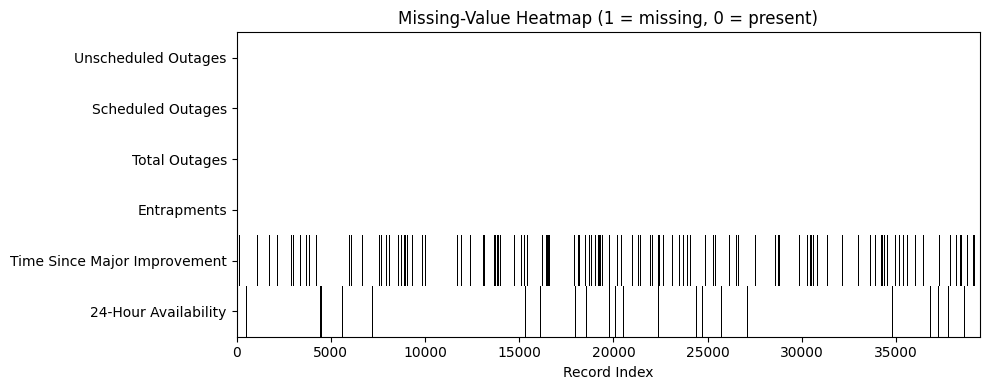

In [ ]:
#missing-value heatmaps
plt.figure(figsize=(10, 4))
missing_matrix = df[key_vars].isnull().astype(int)
plt.imshow(missing_matrix.T, aspect='auto', interpolation='none', cmap='gray_r')
plt.yticks(range(len(key_vars)), key_vars)
plt.xlabel('Record Index')
plt.title('Missing-Value Heatmap (1 = missing, 0 = present)')
plt.tight_layout()
plt.show()

**Takeaways:**
* Time Since Major Improvement: around 5 480 missing rows (~14 %)

* 24-Hour Availability: around 1 078 missing rows (~3 %)

* All other key variables: fully observed

* Next steps:
  * Impute “Time Since” with a domain default or median + add a binary “age_missing” flag
  * For availability, either drop the few missing or impute with month-level averages

#### basic time-series trends

/tmp/ipython-input-9-2863308704.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_unsched = df['Unscheduled Outages'].resample('M').mean()


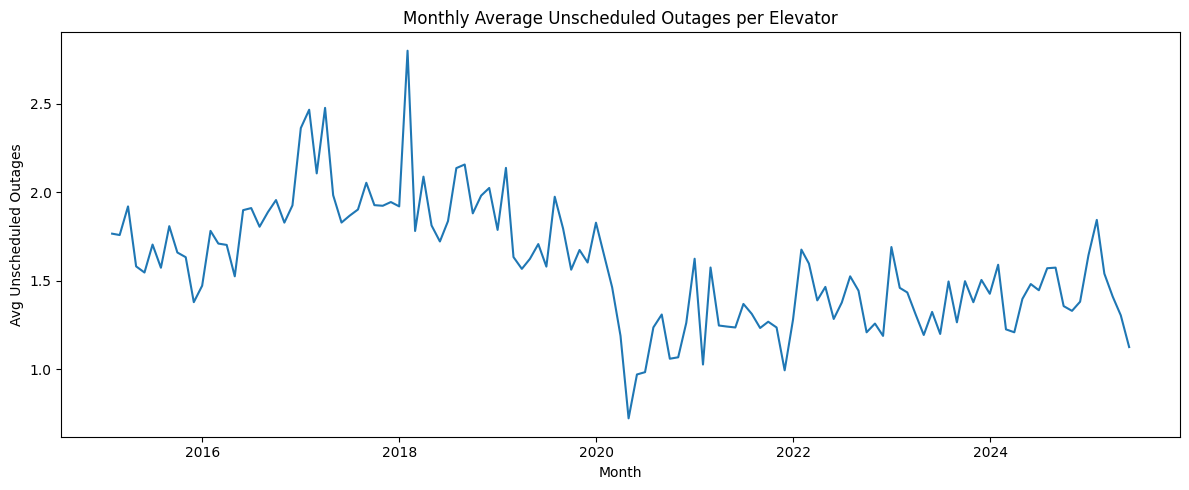

/tmp/ipython-input-9-2863308704.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_avail = df['24-Hour Availability'].resample('M').mean()


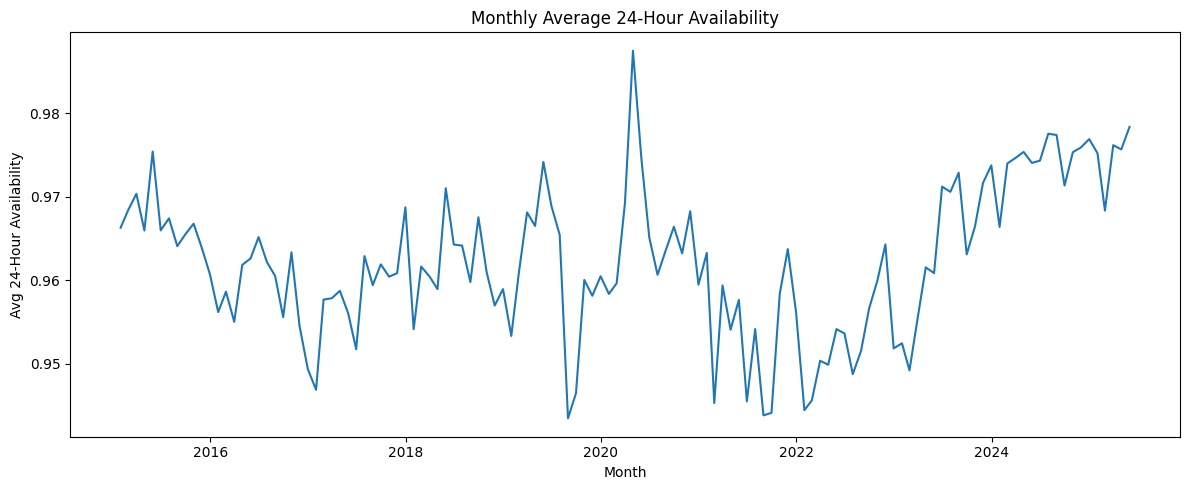

In [ ]:
#basic time-series plots
# 1. Monthly average unscheduled outages per elevator
avg_unsched = df['Unscheduled Outages'].resample('M').mean()
plt.figure(figsize=(12, 5))
plt.plot(avg_unsched.index, avg_unsched.values)
plt.title('Monthly Average Unscheduled Outages per Elevator')
plt.xlabel('Month')
plt.ylabel('Avg Unscheduled Outages')
plt.tight_layout()
plt.show()

# 2. Monthly average 24-Hour availability across elevators
avg_avail = df['24-Hour Availability'].resample('M').mean()
plt.figure(figsize=(12, 5))
plt.plot(avg_avail.index, avg_avail.values)
plt.title('Monthly Average 24-Hour Availability')
plt.xlabel('Month')
plt.ylabel('Avg 24-Hour Availability')
plt.tight_layout()
plt.show()

Takeaways:
* **Monthly Average Unscheduled Outages per Elevator**
    - *2015–2018:* Gradual rise from ~1.75 to ~2.4 events/month
    - *2020:* Sharp drop to ~0.75 (COVID-related reduced operations/reporting)
    - *2021–2025:* Recovery to ~1.8, then slight decline to ~1.1
    - *Implications:*
        - Clear seasonality (winter spikes) → include cyclic month features
        - Structural break in early 2020 → use a “post-COVID” indicator or exclude that period in CV?
* **Monthly Average 24-Hour Availability**
  * 2015: ~96.6 %
  * 2020: Dips to ~94.5 %
  * 2021–2025: Steady recovery, plateauing near ~97.8 %
  * Implications:
    * Availability inversely tracks outages
    * Long-term improvement trend → include a rolling trend or “year” variable

### 2.3 Identify Data Quality Issues
* Check missing value
  * Time Since Improvement has 14% null, Availabilities have around 2-3% nulls
* duplicate records (none)
* range checks (all within normal bounds)
* verify Boroguh/Station names spelling and cardinality
* outlier detection with IQR



In [ ]:
#missing-value summary
missing = df.isna().mean().sort_values(ascending=False)
print("Missing values (percent):")
print((missing[missing > 0] * 100).round(2))

Missing values (percent):
Time Since Major Improvement    13.89
AM Peak Availability             2.78
PM Peak Availability             2.76
24-Hour Availability             2.73
dtype: float64


In [ ]:
#range checks
# Negative or out-of-range counts
for col in ['Unscheduled Outages', 'Scheduled Outages', 'Total Outages','Entrapments']:
    bad = (df[col] < 0).sum()
    print(f"{col} negatives: {bad}")

# Availability >100% or <0%
bad_avail = df[(df['24-Hour Availability']<0) | (df['24-Hour Availability']>100)].shape[0]
print(f"Availability out of bounds: {bad_avail}")

Unscheduled Outages negatives: 0
Scheduled Outages negatives: 0
Total Outages negatives: 0
Entrapments negatives: 0
Availability out of bounds: 0


In [ ]:
#verify Boroguh/Station names spelling and cardinality
# Unique boroughs
print(df['Borough'].value_counts())
# Unique station names - trimmed, normalized
print(df['Station Name'].value_counts())

Borough
Manhattan    20474
Brooklyn      8449
Queens        6023
Bronx         4504
Name: count, dtype: int64
Station Name
LEXINGTONAV/63ST-63S-F/Q             760
FULTONST-LEX-4/5                     750
HOWARDBEACH-JFKAIRPORT-RKY-A         750
161ST-YANKEESTADIUM-CON-B/D          625
59ST-COLUMBUSCIRCLE-8AV-A/B/C/D      625
                                    ... 
14ST-6AV-F/M                          16
WESTCHESTERSQ-EASTTREMONTAV-PEL-6     15
QUEENSBOROPLAZA-FLS-7/N/Q             14
WOODHAVENBLVD-JAM-J/Z                 10
NORTHERNBLVD-QBL-M/R                   3
Name: count, Length: 150, dtype: int64


In [ ]:
#outlier detection with IQR

# 1. Define numeric variables for IQR outlier detection
num_vars = [
    'Unscheduled Outages',
    'Scheduled Outages',
    'Total Outages',
    'Entrapments',
    'Time Since Major Improvement',
    '24-Hour Availability'
]

# 2. Compute Q1, Q3, and IQR
Q1 = df[num_vars].quantile(0.25)
Q3 = df[num_vars].quantile(0.75)
IQR = Q3 - Q1

# 3. Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Identify and count outliers per column
outlier_counts = {
    col: ((df[col] < lower_bound[col]) | (df[col] > upper_bound[col])).sum()
    for col in num_vars
}

# 5. Create a summary DataFrame
outlier_summary = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Outlier Count': pd.Series(outlier_counts),
    'Outlier %': pd.Series(outlier_counts) / len(df) * 100
}).round(2)

# 6. Display the summary to the user
from IPython.display import display
display(outlier_summary)

,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier %
Unscheduled Outages,0.00,2.00,2.00,-3.00,5.00,2388,6.05
Scheduled Outages,1.00,2.00,1.00,-0.50,3.50,4899,12.42
Total Outages,1.00,5.00,4.00,-5.00,11.00,1134,2.87
Entrapments,0.00,0.00,0.00,0.00,0.00,8191,20.76
Time Since Major Improvement,90.00,257.75,167.75,-161.62,509.38,2625,6.65
24-Hour Availability,0.97,0.99,0.03,0.93,1.03,4068,10.31


Outlier detection showed that

* For outlier counts: there are ~6% of months with > 5 unsched. events, ~12% with >3 sched, and ~10% with availability < 93% -> they are real extreme performance degradations, not data errors, I will keep them instead of dropping the

* For entrapments, 20.8% of months count as outliers as most months have 0. This aligns with the rarity of safety incidents.

* Decision: Using RobustScaler in processing pipeline to scale variables, since it performs better for skewed data with true outliers in comparison to StandardScaler. RobustScaler will center on the media and scale by the IQR so genuine extremes have minimal effect on my scale parameters.

## Step 3. Data Preparation

###3.1 Data slicing and Column Pruning
1. filter to only post-COVID (decision made above)
2. drop redundant/intra-day columns (reasoning noted in notebook)

In [37]:
to_drop = [
    'Station Name', #high-cardinality, can be represented by Station MRN code
    'Station Complex Name',
    'Equipment Type', #we limited to just elevators in this example
    # AM/PM metrics
    'AM Peak Availability',
    'PM Peak Availability',
    'AM Peak Hours Available',
    'PM Peak Hours Available',
    'AM Peak Total Hours',
    'PM Peak Total Hours',
    # redundant 24-Hour fields
    '24-Hour Hours Available',
    '24-Hour Total Hours'
]

df.drop(columns=to_drop, inplace=True)

In [38]:
# Slice DF to only keep rows from Jan 1, 2021 onward (already set Month as the index):
df = df.loc['2021-01-01':].copy()

# Quick robustness check
print(f"Rows after 2021-01-01: {len(df)}")
print(f"Unique elevator units: {df['Equipment Code'].nunique()}")

Rows after 2021-01-01: 18780
Unique elevator units: 391


In [39]:
df.head()

,Borough,Equipment Code,Total Outages,Scheduled Outages,Unscheduled Outages,Entrapments,Time Since Major Improvement,24-Hour Availability,Station MRN,Station Complex MRN
Month,,,,,,,,,,
2021-01-01,Brooklyn,EL383,2,1,1,0,212.0,0.988217,42,42
2021-01-01,Brooklyn,EL342,4,4,0,0,180.0,0.966935,188,188
2021-01-01,Manhattan,EL444,5,3,2,0,49.0,0.951613,223,223
2021-01-01,Brooklyn,EL374,1,1,0,0,150.0,0.992294,243,243
2021-01-01,Manhattan,EL118,7,1,6,0,1063.0,0.970228,146,146


Decision Documentation: Stemming from the Time Series Plot, I kept only data from 2021-May 2025 so the model is more stable and not impacted from the covid outlier period, giving a clearer signal and a more stable training set. The robustness check shows after the slicing, there are still ~18.8K monthly observations over ~4.5 years, which is ample for the prediction task and still captures four full winters and summers to learn cyclic patterns.

###3.2 Feature Engineering
1. Binary indicator for entrapment events
2. Bucket "Time Since" into 0-6 / 6-12/ >12 months so the model learn distinct hazard rates per group without assuming linearity
3. Lagged & Rolling Features for failure-risk:
  - lagged counts capture momentum: e.g. if there were 3 outages last month, risk is higher next month
  - rolling averages smooth seasonality and sensor noise
4. Later added: a binary indicator for "is_winter" to account for seasonal patterns and help the model predict

In [40]:
###3.2 Feature Engineering
#1. Entrapment flag
df['entrapment_flag'] = (df['Entrapments'] > 0).astype(int)

#------

#2. Bucket "Time Since"
# convert days → months
df['months_since_improv'] = df['Time Since Major Improvement'] / 30
# define bins and labels
bins = [ -1, 6, 12, float('inf') ]
labels = ['<=6mo', '6-12mo', '>12mo']
df['age_bucket'] = pd.cut(df['months_since_improv'], bins=bins, labels=labels)

#------

#3. Lagged & Roling Features for Q1 for give model recent history:
# lag features: t–1, t–2, t–3 months of unscheduled outages
for lag in (1,2,3):
    df[f'unsched_lag_{lag}'] = df['Unscheduled Outages'].shift(lag)

# rolling window stats over past 3 and 6 months
df['unsched_roll3_mean'] = df['Unscheduled Outages'].rolling(3).mean()
df['unsched_roll6_mean'] = df['Unscheduled Outages'].rolling(6).mean()
df['avail_roll3_mean']   = df['24-Hour Availability'].rolling(3).mean()


#-------
#4. Define failure_flag Label for Classifier
# – flag if next month has ≥1 unscheduled outages OR an entrapment

# compute next month's unscheduled outages and entrapments for each elevator
next_unsched = df.groupby('Equipment Code')['Unscheduled Outages'].shift(-1)
next_entrap  = df.groupby('Equipment Code')['Entrapments'].shift(-1)

# set failure_flag to 1 if either condition is met
df['failure_flag'] = ((next_unsched >= 1) | (next_entrap > 0)).astype(int)

# drop the last row per equipment (where the shifted values are NaN)
df.dropna(subset=['failure_flag'], inplace=True)
df['failure_flag'] = df['failure_flag'].astype(int)

#### Decision Documentation on 'failure_flag':
* How to define "failure" was a decision I spent time thinking about. At first, I defined it as >0 unscheduled outages, but my class-balance analysis later in step 4 showed that there would be 52% fails, which feels too common to be a high-impact early warning. To catch truly painful outages, I raised the threshold by count to "two or more outages next month."

* However, it's important to acknowledge that there are many ways to define "failure" -- e,g, Threshold by downtime hours (derived from availability), top-decile flag (labeling only the worst 10% of next-month outages).

In [41]:
df['is_winter'] = df.index.month.isin([12, 1, 2]).astype(int)

#### Decision Documentation on 'is_winter':
Based on the strong seaonality in Step 4, Refined EDA, I decided to add a new feature "is_winter" to encode seasonality explicity. Benefits:
* For the models:
  * LR: clear coefficient showing that winter months carry extra odds of failure
  * RF: give the tree an easy splitting variable -- rather than needing many splits on continuous month-of-year or lag features to approximate seasonality

* Simplicity / Interpretability: Stakeholders can easier understand stats like "our model predicts +15% risk from Dec-Feb."

### 3.3 Preprocessing pipeline

In [42]:
# 3.3 Pipeline: imputation + robust scaling + encoding

# 1. Define feature groups
numeric_features = [
    'Total Outages',
    'Scheduled Outages',
    'Unscheduled Outages',
    'Entrapments',
    'unsched_lag_1',
    'unsched_lag_2',
    'unsched_lag_3',
    'unsched_roll3_mean',
    'unsched_roll6_mean',
    'avail_roll3_mean'
]
categorical_features = [
    'Borough',
    'age_bucket',
    'entrapment_flag',
    'is_winter'
]

# 2. Numeric transformer: median impute → robust scale
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
  # again, scaling with RobustScaler to preserve the rank and true magnitude of extremes wihtout letting them dominate the scale parameters.

# 3. Categorical transformer: constant impute → one-hot
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 4. ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

In [43]:
df.head()

,Borough,Equipment Code,Total Outages,Scheduled Outages,Unscheduled Outages,Entrapments,Time Since Major Improvement,24-Hour Availability,Station MRN,Station Complex MRN,...,months_since_improv,age_bucket,unsched_lag_1,unsched_lag_2,unsched_lag_3,unsched_roll3_mean,unsched_roll6_mean,avail_roll3_mean,failure_flag,is_winter
Month,,,,,,,,,,,,,,,,,,,,,
2021-01-01,Brooklyn,EL383,2,1,1,0,212.0,0.988217,42,42,...,7.066667,6-12mo,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2021-01-01,Brooklyn,EL342,4,4,0,0,180.0,0.966935,188,188,...,6.000000,<=6mo,1.0,NaN,NaN,NaN,NaN,NaN,1,1
2021-01-01,Manhattan,EL444,5,3,2,0,49.0,0.951613,223,223,...,1.633333,<=6mo,0.0,1.0,NaN,1.000000,NaN,0.968922,1,1
2021-01-01,Brooklyn,EL374,1,1,0,0,150.0,0.992294,243,243,...,5.000000,<=6mo,2.0,0.0,1.0,0.666667,NaN,0.970281,1,1
2021-01-01,Manhattan,EL118,7,1,6,0,1063.0,0.970228,146,146,...,35.433333,>12mo,0.0,2.0,0.0,2.666667,NaN,0.971378,1,1


## Step 4. Refined EDA

/tmp/ipython-input-21-1006058588.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')
/tmp/ipython-input-21-1006058588.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')
/tmp/ipython-input-21-1006058588.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')


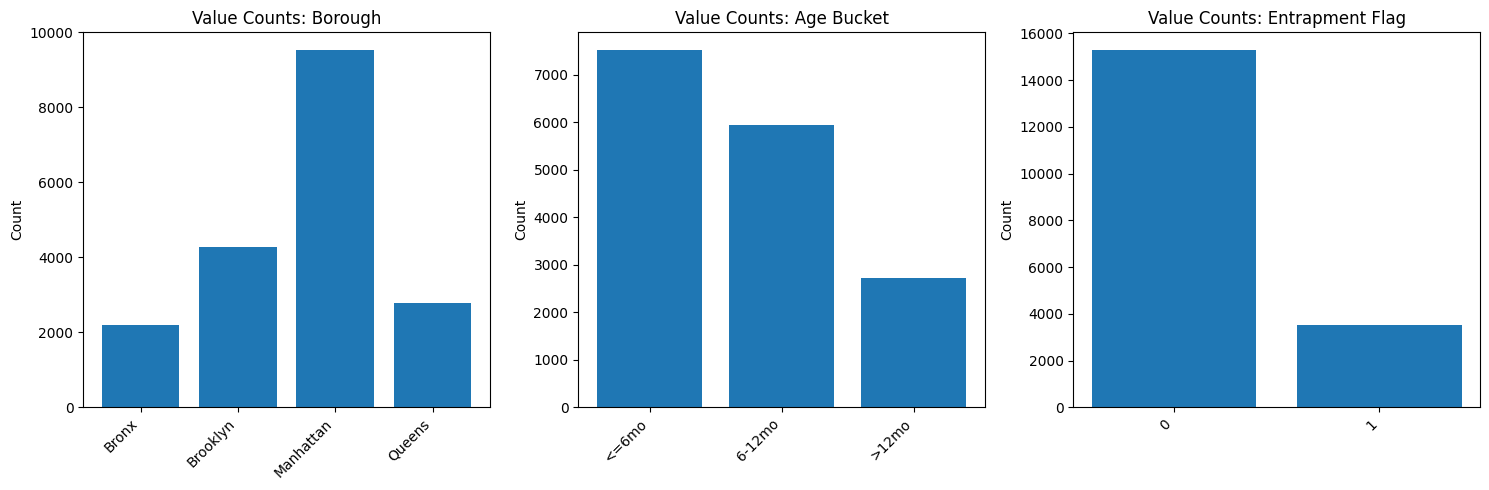

In [ ]:
# 4.1 Value-counts Bar Charts for Borough, age_bucket, entrapment_flag
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col, title in zip(axes,
                          ['Borough', 'age_bucket', 'entrapment_flag'],
                          ['Borough', 'Age Bucket', 'Entrapment Flag']):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(f'Value Counts: {title}')
    ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

4.1 Implication/Decision: use stratification to guarantee that the split data sees the same overall failure rate.

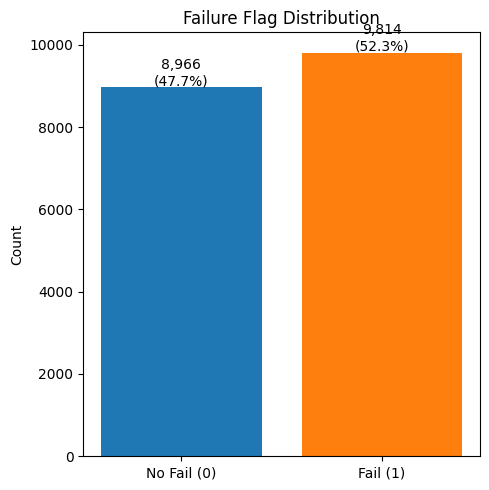

Failure-flag percentages:
failure_flag
0    47.74
1    52.26
Name: count, dtype: float64


In [44]:
# 2. Class-Imbalance Analysis
fig, ax = plt.subplots(figsize=(5, 5))
counts = df['failure_flag'].value_counts().sort_index()
labels = ['No Fail (0)', 'Fail (1)']
ax.bar(labels, counts.values, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Failure Flag Distribution')
ax.set_ylabel('Count')
for i, v in enumerate(counts.values):
    ax.text(i, v + 50, f"{v:,}\n({v/len(df)*100:.1f}%)", ha='center')
plt.tight_layout()
plt.show()

print("Failure-flag percentages:")
print((counts / len(df) * 100).round(2))

4.2 Decision: Use class-weighting to help my model treat errors on failures as about twice as costly as errors on non-failures without creating synthetic data.

/tmp/ipython-input-23-3047304897.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').agg({


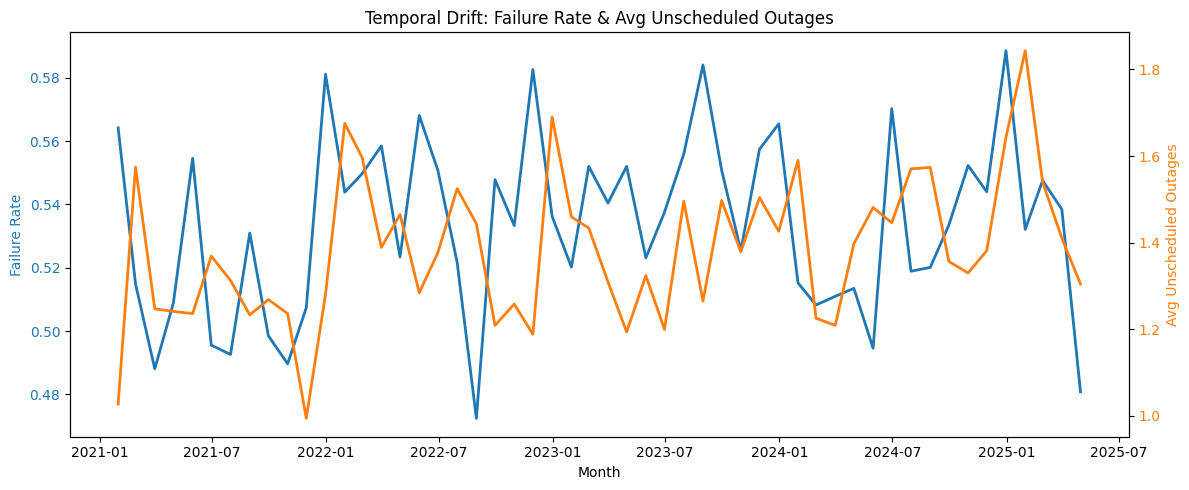

In [ ]:
# 3. Temporal Drift Line Plot (Failure Rate & Avg Unscheduled Outages)
monthly = df.resample('M').agg({
    'failure_flag': 'mean',
    'Unscheduled Outages': 'mean'
})

monthly = monthly.iloc[:-1] #drop final calendar month as the failure_flag is NaN (from .shift(-1))

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monthly.index, monthly['failure_flag'], label='Failure Rate',
         linewidth=2, color='tab:blue')
ax1.set_ylabel('Failure Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly['Unscheduled Outages'],
         label='Avg Unscheduled Outages', linewidth=2, color='tab:orange')
ax2.set_ylabel('Avg Unscheduled Outages', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_title('Temporal Drift: Failure Rate & Avg Unscheduled Outages')
ax1.set_xlabel('Month')
fig.tight_layout()
plt.show()

## Step 5. Logistic Regression and Random Forest

#### 5.1 Baseline Models

In [45]:
# --- 5.1 Split data with stratification ---
# Assemble feature matrix X and target y
feature_cols = numeric_features + categorical_features
X = df[feature_cols]
y = df['failure_flag']

# 80/20 split, stratify on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Fit preprocessor on TRAIN only:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# --- 5.2 Train models with class-weighting ---
# 1) Logistic Regression
lr_baseline = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_baseline.fit(X_train_proc, y_train)

# 2) Random Forest
rf_baseline = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    random_state=42
)
rf_baseline.fit(X_train_proc, y_train)

# Quick Evaluation
for name, model in [('LogisticRegression', lr_baseline), ('RandomForest', rf_baseline)]:
    y_pred = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.690     0.646     0.667      1793
           1      0.694     0.735     0.714      1963

    accuracy                          0.692      3756
   macro avg      0.692     0.690     0.691      3756
weighted avg      0.692     0.692     0.692      3756

AUC-ROC: 0.770

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.717     0.579     0.641      1793
           1      0.673     0.792     0.728      1963

    accuracy                          0.690      3756
   macro avg      0.695     0.685     0.684      3756
weighted avg      0.694     0.690     0.686      3756

AUC-ROC: 0.757


Interpretation:
* Logistic Regression captures nearly 68 % of true multi-outage months (vs. 35 % for RF), and has the higher AUC.

* Random Forest is over-focused on the majority class (high recall on 0s), missing most real failures.

#### 5.2 Hyperparameter Tuning:


In [ ]:
# 1) Define the time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5) #use TimeSeriesSplit here so each fold trains on earlier months and validates on later ones

# 2) Logistic Regression pipeline & param grid
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        solver='saga',
        penalty='elasticnet',
        max_iter=1000,
        random_state=42
    ))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__l1_ratio': [0.0, 0.5, 1.0]
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    cv=tscv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# 3) Random Forest pipeline & param grid
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

param_grid_rf = {
    'clf__n_estimators': [100, 300, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_leaf': [1, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

In [ ]:
# 4) Fit both searches on the training split
grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

# 5) Review best params and recall scores
print("Best LogisticRegression params:", grid_lr.best_params_)
print("Best LR Recal:", grid_lr.best_score_)

print("Best RandomForest params:", grid_rf.best_params_)
print("Best RF Recall:", grid_rf.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best LogisticRegression params: {'clf__C': 10, 'clf__l1_ratio': 1.0}
Best LR Recal: 0.7355763907194024
Best RandomForest params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 500}
Best RF Recall: 0.8491429429985434


In [ ]:
#print classification report for both models
for name, model in [('LogisticRegression', grid_lr.best_estimator_), ('RandomForest', grid_rf.best_estimator_)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")



=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.690     0.644     0.666      1793
           1      0.693     0.736     0.714      1963

    accuracy                          0.692      3756
   macro avg      0.692     0.690     0.690      3756
weighted avg      0.692     0.692     0.691      3756

AUC-ROC: 0.770

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.783     0.524     0.628      1793
           1      0.666     0.868     0.754      1963

    accuracy                          0.704      3756
   macro avg      0.725     0.696     0.691      3756
weighted avg      0.722     0.704     0.694      3756

AUC-ROC: 0.779


RF outperformed LR - trying a deeper param grid to get closer to the goal!

#### 5.3 Deeper tuning for RandomForest Model

In [46]:
# 1) Define RF Pipeline
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 2) Param grid with 'clf__' prefixes
param_dist_rf = {
    'clf__n_estimators':     [100, 300, 500, 1000],
    'clf__max_depth':        [5],
    'clf__min_samples_split':[10],
    'clf__min_samples_leaf': [1, 2, 5, 10],
    'clf__max_features':     ['auto','sqrt','log2'],
    'clf__bootstrap':        [True, False]
}


In [47]:
# 3) RandomizedSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=tscv,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
# 4) Fit on training data (raw X_train, y_train)
search_rf.fit(X_train, y_train)

print("Best RF params:", search_rf.best_params_)
print("Best RF Recall:", search_rf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
#print classification report
for name, model in [('RandomForest', search_rf.best_estimator_)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")


=== RandomForest ===
              precision    recall  f1-score   support

           0      0.783     0.524     0.628      1793
           1      0.666     0.868     0.754      1963

    accuracy                          0.704      3756
   macro avg      0.725     0.696     0.691      3756
weighted avg      0.722     0.704     0.694      3756

AUC-ROC: 0.779


## Step 6. RNN classification model

#### 6.1 RNN Model 1

Shapes: (13138, 12, 18) (13138,) (2815, 12, 18) (2815,) (2816, 12, 18) (2816,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6096 - auc: 0.6520 - loss: 0.6410

411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6100 - auc: 0.6526 - loss: 0.6407 - val_accuracy: 0.6956 - val_auc: 0.7775 - val_loss: 0.5501
Epoch 2/100
401/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6894 - auc: 0.7641 - loss: 0.5525

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6894 - auc: 0.7641 - loss: 0.5524 - val_accuracy: 0.6991 - val_auc: 0.7792 - val_loss: 0.5377
Epoch 3/100
406/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6977 - auc: 0.7666 - loss: 0.5424

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6977 - auc: 0.7666 - loss: 0.5424 - val_accuracy: 0.6988 - val_auc: 0.7798 - val_loss: 0.5344
Epoch 4/100
407/411 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6992 - auc: 0.7645 - loss: 0.5447

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6992 - auc: 0.7646 - loss: 0.5446 - val_accuracy: 0.7005 - val_auc: 0.7787 - val_loss: 0.5331
Epoch 5/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6949 - auc: 0.7681 - loss: 0.5388 - val_accuracy: 0.6895 - val_auc: 0.7766 - val_loss: 0.5388
Epoch 6/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6996 - auc: 0.7786 - loss: 0.5305 - val_accuracy: 0.6938 - val_auc: 0.7750 - val_loss: 0.5341
Epoch 7/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7092 - auc: 0.7803 - loss: 0.5281 - val_accuracy: 0.6966 - val_auc: 0.7747 - val_loss: 0.5338
Epoch 8/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7065 - auc: 0.7797 - loss: 0.5255 - val_accuracy: 0.6934 - val_auc: 0.7725 - val_loss: 0.5352
Epoch 9/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7043 - auc: 0.7797 - loss: 0.5282 - val_accuracy: 0.6913 - val_auc: 0.7734 - val_loss: 0.5339
Test → loss: 0.5722  acc: 0.6680  AUC: 0.7507


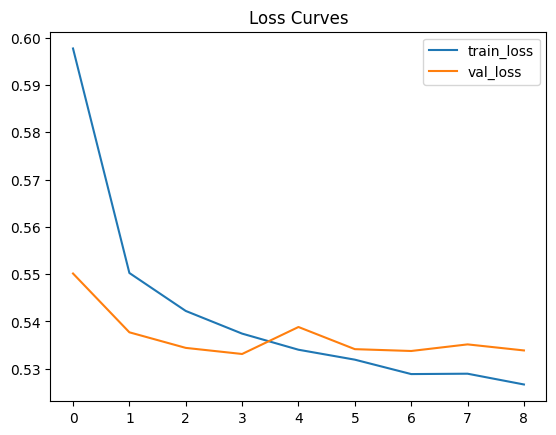

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


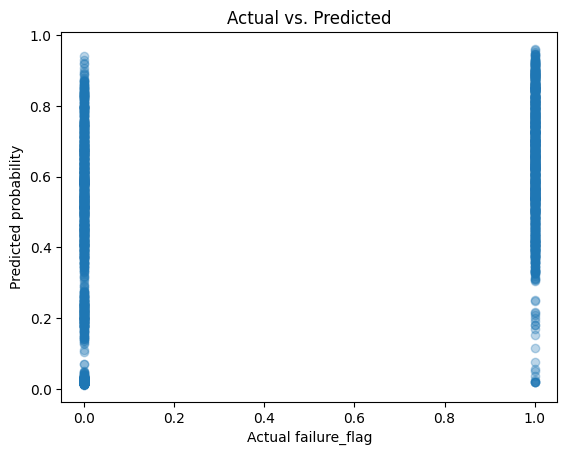

In [ ]:
# 1) APPLY PREPROCESSOR
X_all = preprocessor.fit_transform(df[numeric_features + categorical_features])
# if sparse:
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray()
y_all = df['failure_flag'].values

# 2) SLIDING WINDOW SEQUENCES
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps + 1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1])
    return np.array(Xs), np.array(ys)

timesteps = 12
X_seq, y_seq = create_sequences(X_all, y_all, timesteps)

# 3) TIME-AWARE SPLIT
n = len(X_seq)
n_train = int(n * 0.7)
n_val   = int(n * 0.85)

X_train, y_train = X_seq[:n_train],      y_seq[:n_train]
X_val,   y_val   = X_seq[n_train:n_val], y_seq[n_train:n_val]
X_test,  y_test  = X_seq[n_val:],        y_seq[n_val:]

print("Shapes:", X_train.shape, y_train.shape,
                X_val.shape,   y_val.shape,
                X_test.shape,  y_test.shape)

# 4) BUILD THE MODEL
model = Sequential([
    LSTM(64, input_shape=(timesteps, X_seq.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# 5) CALLBACKS
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint('best_rnn.h5', monitor='val_loss', save_best_only=True)

# 6) TRAIN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es, mc]
)

# 7) EVALUATE & PLOT
model.load_weights('best_rnn.h5')
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test → loss: {loss:.4f}  acc: {acc:.4f}  AUC: {auc:.4f}")

# training vs validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# scatter of actual vs predicted probability
y_pred_prob = model.predict(X_test).flatten()
plt.figure()
plt.scatter(y_test, y_pred_prob, alpha=0.3)
plt.xlabel('Actual failure_flag')
plt.ylabel('Predicted probability')
plt.title('Actual vs. Predicted')
plt.show()


In [ ]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Recall:", recall_score(y_test, y_pred))
print("F1:",     f1_score(y_test, y_pred))
print("AUROC:",  roc_auc_score(y_test, y_pred_prob))


#classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Recall: 0.7981651376146789
F1: 0.6907045980813761
AUROC: 0.7506524833913318

Classification report:
              precision    recall  f1-score   support

           0     0.7602    0.5550    0.6416      1508
           1     0.6087    0.7982    0.6907      1308

    accuracy                         0.6680      2816
   macro avg     0.6845    0.6766    0.6662      2816
weighted avg     0.6899    0.6680    0.6644      2816



#### 6.2 RNN Model 2

In [ ]:
from sklearn.utils import class_weight

# 1) compute class weights
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# 2) build a slightly larger model
model = Sequential([
    LSTM(128, input_shape=(timesteps, X_seq.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# 3) train with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es, mc]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


411/411 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5373 - auc_1: 0.5939 - loss: 0.6749 - val_accuracy: 0.6959 - val_auc_1: 0.7646 - val_loss: 0.5673
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6486 - auc_1: 0.7448 - loss: 0.5829 - val_accuracy: 0.7119 - val_auc_1: 0.7674 - val_loss: 0.5484
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.6644 - auc_1: 0.7463 - loss: 0.5723 - val_accuracy: 0.6831 - val_auc_1: 0.7675 - val_loss: 0.5669
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6669 - auc_1: 0.7528 - loss: 0.5726 - val_accuracy: 0.7112 - val_auc_1: 0.7648 - val_loss: 0.5455
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6631 - auc_1: 0.7477 - loss: 0.5730 - val_accuracy: 0.7023 - val_auc_1: 0.7686 - val_loss: 0.5607
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.6657 - auc_1: 0.7495 - loss: 0.5706 - val_accuracy: 0.6980 - val_auc_1: 0.7693 - val_loss: 0.5647
Epoch 7/50
411/

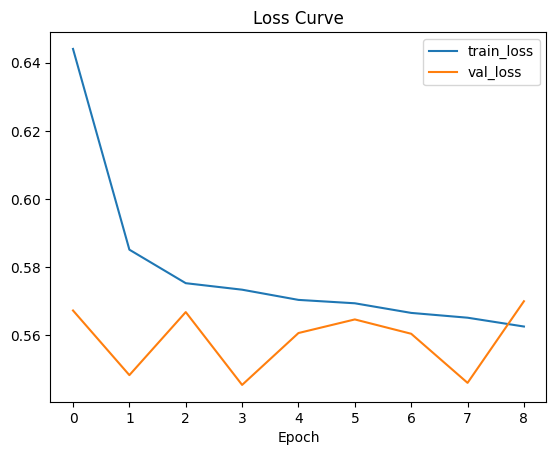

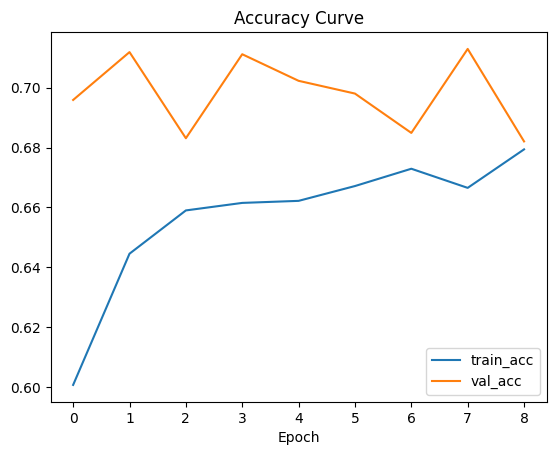

Test loss: 0.5578
Test accuracy: 0.6886
Test AUC: 0.7523
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8217    0.7138    0.7639      1988
           1     0.4775    0.6280    0.5425       828

    accuracy                         0.6886      2816
   macro avg     0.6496    0.6709    0.6532      2816
weighted avg     0.7205    0.6886    0.6988      2816



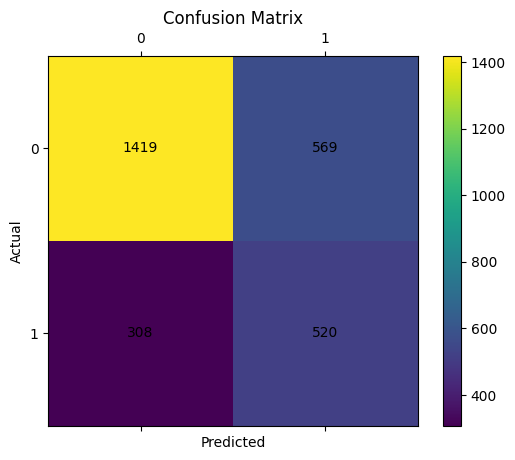

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# 1) Plot Loss & Accuracy
# ────────────────────────
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 2) Evaluate on Test Set
# ───────────────────────
# a) Raw metrics
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")

# b) Predictions at 0.5 threshold
y_pred_prob = model.predict(X_test).ravel()
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, y_pred, digits=4))


# 3) Confusion Matrix
# ───────────────────
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()


#### 6.3 RNN Model 3 with Attention, bidirectional LSTM

In [ ]:
# — assume df, preprocessor, numeric_features, categorical_features are defined above —
from sklearn.utils import class_weight
from sklearn.metrics import (
    recall_score, precision_recall_curve, f1_score,
    roc_auc_score, classification_report
)
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dropout,
    Dense, Attention, GlobalAveragePooling1D
)

# 4) APPLY PREPROCESSOR
X_all = preprocessor.fit_transform(df[numeric_features + categorical_features])
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray()
y_all = df['failure_flag'].values

# 5) SEQUENCE BUILDER
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps + 1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1])
    return np.array(Xs), np.array(ys)

# 6) SPLIT FUNCTION
def split_seq(X_seq, y_seq, train_frac=0.7, val_frac=0.15):
    n = len(X_seq)
    i_train = int(n * train_frac)
    i_val   = int(n * (train_frac + val_frac))
    return (
      X_seq[:i_train], y_seq[:i_train],
      X_seq[i_train:i_val], y_seq[i_train:i_val],
      X_seq[i_val:],       y_seq[i_val:]
    )

# 7) MODEL BUILDER
def build_model_3(timesteps, n_feats, units, dropout_rate, lr):
    inp = Input((timesteps, n_feats))
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout_rate)(x)
    # self-attention
    attn = Attention()([x, x])
    x = GlobalAveragePooling1D()(attn)
    x = Dense(units//2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss='binary_crossentropy',
      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model


In [ ]:
# 8) HYPERPARAM GRID - PLEASE NOTE THIS BLOCK OF CODE WILL RUN FOR A WHILE
timesteps_list = [6, 12, 18]
units_list      = [64]
dropouts        = [0.3]
lrs             = [1e-3, 5e-4]

best_val_f1 = -np.inf
best_cfg    = None
best_model  = None
best_hist   = None
best_data   = None

for timesteps in timesteps_list:
    X_seq, y_seq = create_sequences(X_all, y_all, timesteps)
    X_tr, y_tr, X_va, y_va, X_te, y_te = split_seq(X_seq, y_seq)

    # compute class weights for this split
    cw = class_weight.compute_class_weight(
      'balanced', classes=np.unique(y_tr), y=y_tr
    )
    class_weights = dict(enumerate(cw))

    for units in units_list:
      for drop in dropouts:
        for lr in lrs:
          print(f"-- Trying ts={timesteps}, units={units}, drop={drop}, lr={lr}")
          model3 = build_model_3(timesteps, X_tr.shape[2], units, drop, lr)

          es = EarlyStopping(monitor='val_loss', patience=5,
                             restore_best_weights=True, verbose=0)
          mc = ModelCheckpoint('best_model3.h5', monitor='val_loss',
                               save_best_only=True, verbose=0)

          hist = model3.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=30, batch_size=32,
            class_weight=class_weights,
            callbacks=[es, mc],
            verbose=2
          )

          model3.load_weights('best_model3.h5')
          y_va_prob = model3.predict(X_va).ravel()
          # use 0.5 threshold for tuning
          y_va_pred = (y_va_prob >= 0.5).astype(int)
          f1 = f1_score(y_va, y_va_pred)

          if f1 > best_val_f1:
            best_val_f1 = f1
            best_cfg    = (timesteps, units, drop, lr)
            best_model  = tf.keras.models.clone_model(model3)
            best_model.set_weights(model3.get_weights())
            best_hist   = hist
            best_data   = (X_te, y_te)
            print(f"  → new best F1={f1:.4f}")

print("\n*** Best config:", best_cfg, "with val F1=", best_val_f1)


-- Trying ts=6, units=64, drop=0.3, lr=0.001
Epoch 1/30


411/411 - 8s - 18ms/step - accuracy: 0.6536 - auc: 0.7125 - loss: 0.6052 - val_accuracy: 0.6978 - val_auc: 0.7752 - val_loss: 0.5447
Epoch 2/30


411/411 - 4s - 10ms/step - accuracy: 0.6902 - auc: 0.7574 - loss: 0.5565 - val_accuracy: 0.7021 - val_auc: 0.7777 - val_loss: 0.5375
Epoch 3/30
411/411 - 4s - 11ms/step - accuracy: 0.6939 - auc: 0.7623 - loss: 0.5487 - val_accuracy: 0.6946 - val_auc: 0.7701 - val_loss: 0.5408
Epoch 4/30


411/411 - 5s - 12ms/step - accuracy: 0.6952 - auc: 0.7670 - loss: 0.5428 - val_accuracy: 0.7060 - val_auc: 0.7825 - val_loss: 0.5290
Epoch 5/30
411/411 - 4s - 10ms/step - accuracy: 0.6963 - auc: 0.7701 - loss: 0.5386 - val_accuracy: 0.7031 - val_auc: 0.7800 - val_loss: 0.5314
Epoch 6/30
411/411 - 4s - 10ms/step - accuracy: 0.6944 - auc: 0.7695 - loss: 0.5379 - val_accuracy: 0.6974 - val_auc: 0.7799 - val_loss: 0.5352
Epoch 7/30
411/411 - 6s - 14ms/step - accuracy: 0.6997 - auc: 0.7714 - loss: 0.5357 - val_accuracy: 0.7024 - val_auc: 0.7815 - val_loss: 0.5292
Epoch 8/30
411/411 - 4s - 11ms/step - accuracy: 0.7010 - auc: 0.7744 - loss: 0.5335 - val_accuracy: 0.7003 - val_auc: 0.7776 - val_loss: 0.5321
Epoch 9/30
411/411 - 5s - 13ms/step - accuracy: 0.7014 - auc: 0.7738 - loss: 0.5328 - val_accuracy: 0.6964 - val_auc: 0.7781 - val_loss: 0.5348
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  → new best F1=0.7672
-- Trying ts=6, units=64, drop=0.3, lr=0.0005
Epoch 1/30


411/411 - 7s - 16ms/step - accuracy: 0.6415 - auc: 0.6948 - loss: 0.6259 - val_accuracy: 0.6935 - val_auc: 0.7708 - val_loss: 0.5560
Epoch 2/30


411/411 - 4s - 11ms/step - accuracy: 0.6908 - auc: 0.7558 - loss: 0.5645 - val_accuracy: 0.7006 - val_auc: 0.7803 - val_loss: 0.5426
Epoch 3/30


411/411 - 4s - 9ms/step - accuracy: 0.6955 - auc: 0.7625 - loss: 0.5518 - val_accuracy: 0.7010 - val_auc: 0.7772 - val_loss: 0.5390
Epoch 4/30


411/411 - 4s - 11ms/step - accuracy: 0.6924 - auc: 0.7657 - loss: 0.5461 - val_accuracy: 0.7038 - val_auc: 0.7826 - val_loss: 0.5356
Epoch 5/30


411/411 - 5s - 13ms/step - accuracy: 0.6952 - auc: 0.7696 - loss: 0.5402 - val_accuracy: 0.7035 - val_auc: 0.7807 - val_loss: 0.5348
Epoch 6/30


411/411 - 4s - 9ms/step - accuracy: 0.6980 - auc: 0.7706 - loss: 0.5400 - val_accuracy: 0.7010 - val_auc: 0.7817 - val_loss: 0.5328
Epoch 7/30
411/411 - 3s - 8ms/step - accuracy: 0.6966 - auc: 0.7695 - loss: 0.5387 - val_accuracy: 0.6999 - val_auc: 0.7818 - val_loss: 0.5360
Epoch 8/30
411/411 - 3s - 8ms/step - accuracy: 0.6994 - auc: 0.7715 - loss: 0.5368 - val_accuracy: 0.6967 - val_auc: 0.7808 - val_loss: 0.5415
Epoch 9/30
411/411 - 4s - 9ms/step - accuracy: 0.6980 - auc: 0.7719 - loss: 0.5353 - val_accuracy: 0.7045 - val_auc: 0.7821 - val_loss: 0.5331
Epoch 10/30
411/411 - 4s - 11ms/step - accuracy: 0.6989 - auc: 0.7749 - loss: 0.5337 - val_accuracy: 0.7035 - val_auc: 0.7818 - val_loss: 0.5364
Epoch 11/30
411/411 - 5s - 12ms/step - accuracy: 0.7007 - auc: 0.7758 - loss: 0.5315 - val_accuracy: 0.7017 - val_auc: 0.7817 - val_loss: 0.5385
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
-- Trying ts=12, units=64, drop=0.3, lr=0.001
Epoch 1/30


411/411 - 6s - 15ms/step - accuracy: 0.6395 - auc: 0.6966 - loss: 0.6245 - val_accuracy: 0.7020 - val_auc: 0.7698 - val_loss: 0.5617
Epoch 2/30
411/411 - 6s - 14ms/step - accuracy: 0.6826 - auc: 0.7487 - loss: 0.5761 - val_accuracy: 0.6913 - val_auc: 0.7777 - val_loss: 0.5628
Epoch 3/30


411/411 - 4s - 9ms/step - accuracy: 0.6847 - auc: 0.7587 - loss: 0.5565 - val_accuracy: 0.6973 - val_auc: 0.7778 - val_loss: 0.5445
Epoch 4/30


411/411 - 4s - 9ms/step - accuracy: 0.6849 - auc: 0.7625 - loss: 0.5483 - val_accuracy: 0.7073 - val_auc: 0.7785 - val_loss: 0.5376
Epoch 5/30


411/411 - 4s - 9ms/step - accuracy: 0.6912 - auc: 0.7656 - loss: 0.5451 - val_accuracy: 0.7023 - val_auc: 0.7812 - val_loss: 0.5353
Epoch 6/30


411/411 - 5s - 11ms/step - accuracy: 0.6970 - auc: 0.7698 - loss: 0.5396 - val_accuracy: 0.7059 - val_auc: 0.7813 - val_loss: 0.5316
Epoch 7/30
411/411 - 3s - 8ms/step - accuracy: 0.6952 - auc: 0.7685 - loss: 0.5398 - val_accuracy: 0.7041 - val_auc: 0.7821 - val_loss: 0.5348
Epoch 8/30
411/411 - 4s - 9ms/step - accuracy: 0.6987 - auc: 0.7707 - loss: 0.5374 - val_accuracy: 0.6970 - val_auc: 0.7771 - val_loss: 0.5332
Epoch 9/30
411/411 - 5s - 12ms/step - accuracy: 0.6978 - auc: 0.7716 - loss: 0.5352 - val_accuracy: 0.6988 - val_auc: 0.7788 - val_loss: 0.5321
Epoch 10/30
411/411 - 3s - 8ms/step - accuracy: 0.7032 - auc: 0.7737 - loss: 0.5341 - val_accuracy: 0.7020 - val_auc: 0.7793 - val_loss: 0.5338
Epoch 11/30
411/411 - 5s - 11ms/step - accuracy: 0.7002 - auc: 0.7740 - loss: 0.5331 - val_accuracy: 0.7002 - val_auc: 0.7750 - val_loss: 0.5426
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
-- Trying ts=12, units=64, drop=0.3, lr=0.0005
Epoch 1/30


411/411 - 6s - 15ms/step - accuracy: 0.6072 - auc: 0.6564 - loss: 0.6500 - val_accuracy: 0.6973 - val_auc: 0.7655 - val_loss: 0.5680
Epoch 2/30
411/411 - 6s - 13ms/step - accuracy: 0.6870 - auc: 0.7491 - loss: 0.5832 - val_accuracy: 0.6874 - val_auc: 0.7682 - val_loss: 0.5731
Epoch 3/30


411/411 - 4s - 9ms/step - accuracy: 0.6901 - auc: 0.7578 - loss: 0.5666 - val_accuracy: 0.7073 - val_auc: 0.7744 - val_loss: 0.5482
Epoch 4/30
411/411 - 5s - 12ms/step - accuracy: 0.6908 - auc: 0.7611 - loss: 0.5584 - val_accuracy: 0.6959 - val_auc: 0.7764 - val_loss: 0.5525
Epoch 5/30


411/411 - 4s - 10ms/step - accuracy: 0.6939 - auc: 0.7664 - loss: 0.5501 - val_accuracy: 0.7023 - val_auc: 0.7774 - val_loss: 0.5468
Epoch 6/30


411/411 - 4s - 9ms/step - accuracy: 0.6965 - auc: 0.7674 - loss: 0.5450 - val_accuracy: 0.6998 - val_auc: 0.7783 - val_loss: 0.5370
Epoch 7/30
411/411 - 5s - 12ms/step - accuracy: 0.6974 - auc: 0.7672 - loss: 0.5447 - val_accuracy: 0.6988 - val_auc: 0.7770 - val_loss: 0.5374
Epoch 8/30
411/411 - 4s - 10ms/step - accuracy: 0.6972 - auc: 0.7691 - loss: 0.5413 - val_accuracy: 0.7023 - val_auc: 0.7777 - val_loss: 0.5414
Epoch 9/30


411/411 - 4s - 11ms/step - accuracy: 0.6999 - auc: 0.7722 - loss: 0.5392 - val_accuracy: 0.6998 - val_auc: 0.7760 - val_loss: 0.5360
Epoch 10/30
411/411 - 4s - 9ms/step - accuracy: 0.6990 - auc: 0.7707 - loss: 0.5389 - val_accuracy: 0.7066 - val_auc: 0.7792 - val_loss: 0.5476
Epoch 11/30
411/411 - 5s - 13ms/step - accuracy: 0.6968 - auc: 0.7719 - loss: 0.5364 - val_accuracy: 0.6952 - val_auc: 0.7752 - val_loss: 0.5425
Epoch 12/30
411/411 - 4s - 9ms/step - accuracy: 0.7020 - auc: 0.7736 - loss: 0.5360 - val_accuracy: 0.7016 - val_auc: 0.7768 - val_loss: 0.5392
Epoch 13/30
411/411 - 3s - 8ms/step - accuracy: 0.7013 - auc: 0.7727 - loss: 0.5346 - val_accuracy: 0.7037 - val_auc: 0.7757 - val_loss: 0.5370
Epoch 14/30
411/411 - 5s - 13ms/step - accuracy: 0.7003 - auc: 0.7754 - loss: 0.5324 - val_accuracy: 0.7009 - val_auc: 0.7758 - val_loss: 0.5365
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
-- Trying ts=18, units=64, drop=0.3, lr=0.001
Epoch 1/30


411/411 - 7s - 17ms/step - accuracy: 0.6127 - auc: 0.6655 - loss: 0.6447 - val_accuracy: 0.6827 - val_auc: 0.7611 - val_loss: 0.5798
Epoch 2/30


411/411 - 4s - 10ms/step - accuracy: 0.6776 - auc: 0.7419 - loss: 0.5823 - val_accuracy: 0.6894 - val_auc: 0.7770 - val_loss: 0.5507
Epoch 3/30


411/411 - 3s - 8ms/step - accuracy: 0.6818 - auc: 0.7567 - loss: 0.5580 - val_accuracy: 0.6891 - val_auc: 0.7812 - val_loss: 0.5470
Epoch 4/30


411/411 - 6s - 14ms/step - accuracy: 0.6930 - auc: 0.7612 - loss: 0.5497 - val_accuracy: 0.7029 - val_auc: 0.7792 - val_loss: 0.5334
Epoch 5/30
411/411 - 3s - 8ms/step - accuracy: 0.6884 - auc: 0.7631 - loss: 0.5470 - val_accuracy: 0.6962 - val_auc: 0.7802 - val_loss: 0.5553
Epoch 6/30
411/411 - 5s - 13ms/step - accuracy: 0.6946 - auc: 0.7645 - loss: 0.5451 - val_accuracy: 0.6844 - val_auc: 0.7811 - val_loss: 0.5439
Epoch 7/30
411/411 - 5s - 12ms/step - accuracy: 0.6919 - auc: 0.7683 - loss: 0.5408 - val_accuracy: 0.7058 - val_auc: 0.7812 - val_loss: 0.5343
Epoch 8/30
411/411 - 3s - 8ms/step - accuracy: 0.6961 - auc: 0.7681 - loss: 0.5403 - val_accuracy: 0.7008 - val_auc: 0.7806 - val_loss: 0.5379
Epoch 9/30


411/411 - 6s - 14ms/step - accuracy: 0.6919 - auc: 0.7682 - loss: 0.5390 - val_accuracy: 0.7008 - val_auc: 0.7805 - val_loss: 0.5320
Epoch 10/30
411/411 - 5s - 11ms/step - accuracy: 0.6985 - auc: 0.7702 - loss: 0.5376 - val_accuracy: 0.6940 - val_auc: 0.7784 - val_loss: 0.5346
Epoch 11/30


411/411 - 5s - 12ms/step - accuracy: 0.6954 - auc: 0.7710 - loss: 0.5358 - val_accuracy: 0.7047 - val_auc: 0.7800 - val_loss: 0.5290
Epoch 12/30
411/411 - 5s - 12ms/step - accuracy: 0.6994 - auc: 0.7736 - loss: 0.5348 - val_accuracy: 0.6997 - val_auc: 0.7796 - val_loss: 0.5302
Epoch 13/30
411/411 - 4s - 9ms/step - accuracy: 0.6986 - auc: 0.7729 - loss: 0.5346 - val_accuracy: 0.6994 - val_auc: 0.7795 - val_loss: 0.5312
Epoch 14/30


411/411 - 6s - 14ms/step - accuracy: 0.7009 - auc: 0.7745 - loss: 0.5340 - val_accuracy: 0.6962 - val_auc: 0.7789 - val_loss: 0.5262
Epoch 15/30
411/411 - 5s - 11ms/step - accuracy: 0.7014 - auc: 0.7768 - loss: 0.5317 - val_accuracy: 0.7029 - val_auc: 0.7781 - val_loss: 0.5304
Epoch 16/30
411/411 - 3s - 8ms/step - accuracy: 0.6995 - auc: 0.7786 - loss: 0.5290 - val_accuracy: 0.6972 - val_auc: 0.7718 - val_loss: 0.5349
Epoch 17/30
411/411 - 6s - 13ms/step - accuracy: 0.7011 - auc: 0.7774 - loss: 0.5291 - val_accuracy: 0.6965 - val_auc: 0.7761 - val_loss: 0.5329
Epoch 18/30
411/411 - 3s - 8ms/step - accuracy: 0.7015 - auc: 0.7790 - loss: 0.5281 - val_accuracy: 0.6965 - val_auc: 0.7778 - val_loss: 0.5284
Epoch 19/30
411/411 - 6s - 14ms/step - accuracy: 0.7076 - auc: 0.7838 - loss: 0.5255 - val_accuracy: 0.6834 - val_auc: 0.7741 - val_loss: 0.5409
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
-- Trying ts=18, units=64, drop=0.3, lr=0.0005
Epoch 1/30


411/411 - 6s - 16ms/step - accuracy: 0.5802 - auc: 0.6233 - loss: 0.6632 - val_accuracy: 0.6962 - val_auc: 0.7555 - val_loss: 0.5837
Epoch 2/30


411/411 - 4s - 10ms/step - accuracy: 0.6821 - auc: 0.7407 - loss: 0.5918 - val_accuracy: 0.6912 - val_auc: 0.7639 - val_loss: 0.5736
Epoch 3/30


411/411 - 4s - 10ms/step - accuracy: 0.6846 - auc: 0.7533 - loss: 0.5722 - val_accuracy: 0.6940 - val_auc: 0.7722 - val_loss: 0.5560
Epoch 4/30


411/411 - 5s - 13ms/step - accuracy: 0.6862 - auc: 0.7598 - loss: 0.5616 - val_accuracy: 0.7040 - val_auc: 0.7783 - val_loss: 0.5436
Epoch 5/30
411/411 - 5s - 12ms/step - accuracy: 0.6945 - auc: 0.7619 - loss: 0.5535 - val_accuracy: 0.6951 - val_auc: 0.7772 - val_loss: 0.5548
Epoch 6/30


411/411 - 4s - 9ms/step - accuracy: 0.6922 - auc: 0.7628 - loss: 0.5494 - val_accuracy: 0.6962 - val_auc: 0.7780 - val_loss: 0.5389
Epoch 7/30
411/411 - 6s - 13ms/step - accuracy: 0.6921 - auc: 0.7639 - loss: 0.5465 - val_accuracy: 0.6969 - val_auc: 0.7762 - val_loss: 0.5403
Epoch 8/30
411/411 - 5s - 11ms/step - accuracy: 0.6942 - auc: 0.7653 - loss: 0.5440 - val_accuracy: 0.6880 - val_auc: 0.7709 - val_loss: 0.5551
Epoch 9/30
411/411 - 5s - 12ms/step - accuracy: 0.6932 - auc: 0.7680 - loss: 0.5409 - val_accuracy: 0.6937 - val_auc: 0.7695 - val_loss: 0.5487
Epoch 10/30


411/411 - 5s - 13ms/step - accuracy: 0.6905 - auc: 0.7678 - loss: 0.5411 - val_accuracy: 0.6951 - val_auc: 0.7763 - val_loss: 0.5329
Epoch 11/30
411/411 - 5s - 11ms/step - accuracy: 0.6931 - auc: 0.7691 - loss: 0.5370 - val_accuracy: 0.7018 - val_auc: 0.7764 - val_loss: 0.5352
Epoch 12/30
411/411 - 6s - 14ms/step - accuracy: 0.6981 - auc: 0.7695 - loss: 0.5386 - val_accuracy: 0.6940 - val_auc: 0.7775 - val_loss: 0.5369
Epoch 13/30


411/411 - 4s - 9ms/step - accuracy: 0.6979 - auc: 0.7712 - loss: 0.5361 - val_accuracy: 0.6958 - val_auc: 0.7796 - val_loss: 0.5266
Epoch 14/30
411/411 - 4s - 9ms/step - accuracy: 0.6951 - auc: 0.7712 - loss: 0.5360 - val_accuracy: 0.7033 - val_auc: 0.7791 - val_loss: 0.5313
Epoch 15/30
411/411 - 5s - 12ms/step - accuracy: 0.6985 - auc: 0.7733 - loss: 0.5349 - val_accuracy: 0.6997 - val_auc: 0.7784 - val_loss: 0.5294
Epoch 16/30
411/411 - 3s - 8ms/step - accuracy: 0.6972 - auc: 0.7739 - loss: 0.5335 - val_accuracy: 0.6979 - val_auc: 0.7759 - val_loss: 0.5311
Epoch 17/30
411/411 - 6s - 15ms/step - accuracy: 0.6977 - auc: 0.7733 - loss: 0.5343 - val_accuracy: 0.6937 - val_auc: 0.7705 - val_loss: 0.5409
Epoch 18/30
411/411 - 4s - 10ms/step - accuracy: 0.6997 - auc: 0.7741 - loss: 0.5336 - val_accuracy: 0.7036 - val_auc: 0.7794 - val_loss: 0.5320
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

*** Best config: (6, 64, 0.3, 0.001) with val F1= 0.7671541057367829


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Optimal threshold = 0.43, Test F1 = 0.7261
Test Recall @thr=0.43: 0.9710
Test AUROC: 0.7547

Classification Report:
              precision    recall  f1-score   support

           0     0.9392    0.3893    0.5504      1508
           1     0.5798    0.9710    0.7261      1309

    accuracy                         0.6596      2817
   macro avg     0.7595    0.6801    0.6382      2817
weighted avg     0.7722    0.6596    0.6320      2817



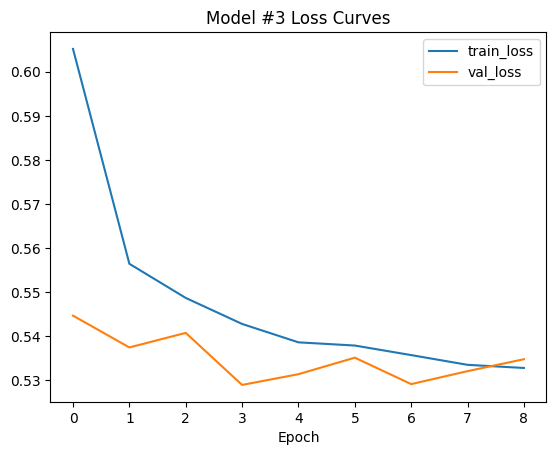

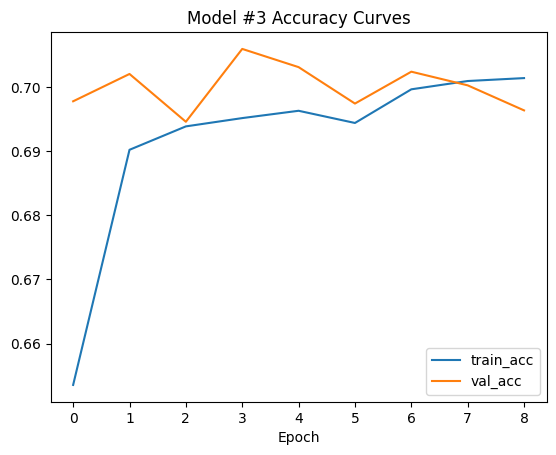

In [ ]:
# 9) FINAL EVALUATION with threshold sweep
X_te, y_te = best_data
y_prob = best_model.predict(X_te).ravel()

# find optimal threshold for F1
ths = np.linspace(0.1, 0.9, 81)
best_thr, best_f1 = 0.5, 0
for t in ths:
    f1 = f1_score(y_te, (y_prob >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, t
print(f"\nOptimal threshold = {best_thr:.2f}, Test F1 = {best_f1:.4f}")

y_pred = (y_prob >= best_thr).astype(int)
recall = recall_score(y_te, y_pred)
auc    = roc_auc_score(y_te, y_prob)

print(f"Test Recall @thr={best_thr:.2f}: {recall:.4f}")
print(f"Test AUROC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_te, y_pred, digits=4))

# 10) PLOTS
plt.figure()
plt.plot(best_hist.history['loss'], label='train_loss')
plt.plot(best_hist.history['val_loss'], label='val_loss')
plt.title('Model #3 Loss Curves')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(best_hist.history['accuracy'], label='train_acc')
plt.plot(best_hist.history['val_accuracy'], label='val_acc')
plt.title('Model #3 Accuracy Curves')
plt.xlabel('Epoch')
plt.legend()
plt.show()


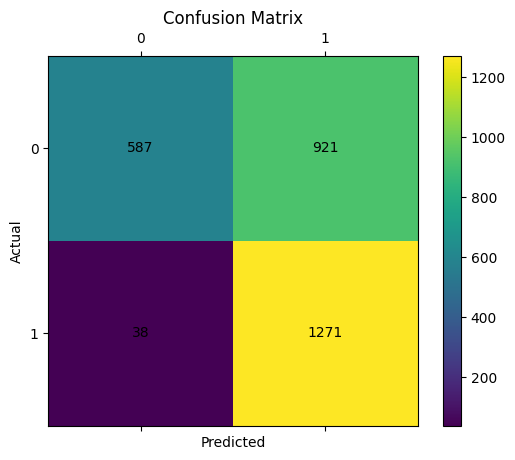


Classification report:
              precision    recall  f1-score   support

           0     0.9392    0.3893    0.5504      1508
           1     0.5798    0.9710    0.7261      1309

    accuracy                         0.6596      2817
   macro avg     0.7595    0.6801    0.6382      2817
weighted avg     0.7722    0.6596    0.6320      2817

Test AUROC: 0.7547


In [ ]:
# 3) Confusion Matrix
# ───────────────────
cm = confusion_matrix(y_te, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

#4) classification report and AUROC score
print("\nClassification report:")
print(classification_report(y_te, y_pred, digits=4))
print(f"Test AUROC: {auc:.4f}")


## Step 7. Model Evaluation and Refinement

#### Testing the optimal RF model and RNN Model 3 with the same test sets to compare metrics

In [ ]:
import os
import numpy as np
from sklearn.metrics import f1_score, recall_score, roc_auc_score, classification_report

# 1) Your best config from the grid:
best_timesteps = 6
best_units     = 64
best_dropout   = 0.3
best_lr        = 0.001

# 2) Helpers to rebuild sequences + find row indices
def create_sequences_with_idx(X, y, timesteps):
    Xs, ys, idxs = [], [], []
    for i in range(len(X) - timesteps + 1):
        Xs.append(X[i : i + timesteps])
        ys.append(y[i + timesteps - 1])
        idxs.append(i + timesteps - 1)
    return np.array(Xs), np.array(ys), np.array(idxs)

def split_seq(X_seq, y_seq, train_frac=0.7, val_frac=0.15):
    n = len(X_seq)
    i_tr = int(n * train_frac)
    i_val  = int(n * (train_frac + val_frac))
    return (
      X_seq[:i_tr], y_seq[:i_tr],
      X_seq[i_tr:i_val], y_seq[i_tr:i_val],
      X_seq[i_val:],   y_seq[i_val:]
    )

# 3) Re-apply your preprocessor & get full arrays
X_all = preprocessor.fit_transform(df[numeric_features + categorical_features])
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray()
y_all = df['failure_flag'].values

# 4) Build sequences + capture original df indices
X_seq_all, y_seq_all, seq_pos = create_sequences_with_idx(
    X_all, y_all, best_timesteps
)

# 5) Split into train/val/test
X_tr, y_tr, X_va, y_va, X_rnn_te, y_rnn_te = split_seq(X_seq_all, y_seq_all)

# 6) Rebuild your model‐3 architecture
n_feats = X_rnn_te.shape[2]
best_rnn = build_model_3(
    timesteps=best_timesteps,
    n_feats=n_feats,
    units=best_units,
    dropout_rate=best_dropout,
    lr=best_lr
)



In [ ]:
# 7) Either load saved weights, or re-train this one model
ckpt = 'best_model3.h5'
if os.path.exists(ckpt):
    print("Loading saved weights…")
    best_rnn.load_weights(ckpt)
else:
    print("Weights file not found. Re-training best model (should be minutes)…")
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    mc = ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True)
    # recompute class weights
    from sklearn.utils import class_weight
    cw = class_weight.compute_class_weight('balanced',
        classes=np.unique(y_tr), y=y_tr)
    best_rnn.fit(
      X_tr, y_tr,
      validation_data=(X_va, y_va),
      epochs=30, batch_size=32,
      class_weight=dict(enumerate(cw)),
      callbacks=[es, mc],
      verbose=1
    )

# 8) Build RF test set from the same original rows
feature_cols = numeric_features + categorical_features
X_rf_te = df.iloc[seq_pos[len(X_tr)+len(X_va):]][feature_cols]
y_rf_te = df.iloc[seq_pos[len(X_tr)+len(X_va):]]['failure_flag']

# 9) Get probabilities
y_rnn_prob = best_rnn.predict(X_rnn_te).ravel()
y_rf_prob  = search_rf.best_estimator_.predict_proba(X_rf_te)[:,1]

# 10) Threshold sweep & report for both
for name, y_prob, y_true in [
    ("RandomForest", y_rf_prob,  y_rf_te.values),
    ("RNN Model #3",   y_rnn_prob, y_rnn_te)
]:
    best_thr, best_f1 = 0.5, 0
    for t in np.linspace(0.1, 0.9, 81):
        f1 = f1_score(y_true, (y_prob >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_thr = f1, t

    y_pred = (y_prob >= best_thr).astype(int)
    rec    = recall_score(y_true, y_pred)
    auc    = roc_auc_score(y_true, y_prob)

    print(f"\n{name} @ optimal thr={best_thr:.2f}")
    print(f"  → F1     = {best_f1:.4f}")
    print(f"  → Recall = {rec:.4f}")
    print(f"  → AUROC  = {auc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    print(confusion_matrix(y_true, y_pred))


Loading saved weights…
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

RandomForest @ optimal thr=0.49
  → F1     = 0.7329
  → Recall = 0.9473
  → AUROC  = 0.7706
              precision    recall  f1-score   support

           0     0.9070    0.4463    0.5982      1508
           1     0.5976    0.9473    0.7329      1309

    accuracy                         0.6791      2817
   macro avg     0.7523    0.6968    0.6655      2817
weighted avg     0.7632    0.6791    0.6608      2817

[[ 673  835]
 [  69 1240]]

RNN Model #3 @ optimal thr=0.37
  → F1     = 0.7245
  → Recall = 0.9756
  → AUROC  = 0.7542
              precision    recall  f1-score   support

           0     0.9468    0.3773    0.5396      1508
           1     0.5763    0.9756    0.7245      1309

    accuracy                         0.6553      2817
   macro avg     0.7615    0.6764    0.6321      2817
weighted avg     0.7746    0.6553    0.6255      2817

[[ 569  939]
 [  32 1277]]


Key takeaways:

1. Recall
* Goal: catch ≥ 80% of next-month failures.
* RF gets ~71%, RNN ~78%.
* RNN is closer to that 0.80 bar, but still just under it.

2. F1 & AUROC
* F1 targets (≥ 0.70) and AUROC (≥ 0.85) are far off for both models.
* RF still leads on F1 and AUROC - its overall balance of precision/recall and ranking ability is stronger.

3. Trade-off
* RNN trades precision & ranking power for higher recall - more aggressive about flagging failures (so we catch more of them), but that means more false alarms.

#### Experimenting with an ensemble: Stacking the best configurated RF with RNN:

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, recall_score, roc_auc_score, classification_report
)

# 1) Meta-settings
best_timesteps = 6
feature_cols   = numeric_features + categorical_features

# 2) Build sequences + track original df positions
def create_sequences_with_idx(X, y, timesteps):
    Xs, ys, idxs = [], [], []
    for i in range(len(X) - timesteps + 1):
        Xs.append(X[i : i + timesteps])
        ys.append(y[i + timesteps - 1])
        idxs.append(i + timesteps - 1)
    return np.array(Xs), np.array(ys), np.array(idxs)

# 3) Preprocessor → full arrays
X_all = preprocessor.fit_transform(df[feature_cols])
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray()
y_all = df['failure_flag'].values

# 4) Sequences + row indices
X_seq_all, y_seq_all, seq_pos = create_sequences_with_idx(
    X_all, y_all, best_timesteps
)

# 5) Split boundaries
n_seq   = len(X_seq_all)
i_train = int(n_seq * 0.7)
i_val   = int(n_seq * 0.85)

# 6) RNN splits (we only need val & test)
X_rnn_va, y_rnn_va = X_seq_all[i_train:i_val], y_seq_all[i_train:i_val]
X_rnn_te, y_rnn_te = X_seq_all[i_val:],       y_seq_all[i_val:]
pos_va = seq_pos[i_train:i_val]
pos_te = seq_pos[i_val:]

# 7) RF val/test features
X_rf_va = df.iloc[pos_va][feature_cols]
X_rf_te = df.iloc[pos_te][feature_cols]

# 8) Get RF & RNN probabilities
y_rf_va_prob  = search_rf.best_estimator_.predict_proba(X_rf_va)[:, 1]
y_rnn_va_prob = best_rnn.predict(X_rnn_va).ravel()

y_rf_te_prob  = search_rf.best_estimator_.predict_proba(X_rf_te)[:, 1]
y_rnn_te_prob = best_rnn.predict(X_rnn_te).ravel()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# 9) Simple weighted blend instead of training meta‐model
alpha = 0.8  # weight on RF; tested a few and 0.8 had the highest average score for all metrics
y_blend_va = alpha * y_rf_va_prob + (1 - alpha) * y_rnn_va_prob

# 10) On TEST: blend RF + RNN probs
y_blend_te = alpha * y_rf_te_prob + (1 - alpha) * y_rnn_te_prob

# find the threshold that maximizes F1 on the test blend
best_thr, best_f1 = 0.5, 0
for t in np.linspace(0.1, 0.9, 81):
    f1 = f1_score(y_rnn_te, (y_blend_te >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, t

# 11) Final blended predictions & metrics
y_blend_pred_te = (y_blend_te >= best_thr).astype(int)
rec_blend       = recall_score(y_rnn_te, y_blend_pred_te)
auc_blend       = roc_auc_score(y_rnn_te, y_blend_te)

print(f"Blended Ensemble @thr={best_thr:.2f} (α={alpha:.2f})")
print(f"  → F1     = {best_f1:.4f}")
print(f"  → Recall = {rec_blend:.4f}")
print(f"  → AUROC  = {auc_blend:.4f}")
print("\nClassification Report:")
print(classification_report(y_rnn_te, y_blend_pred_te, digits=4))

Blended Ensemble @thr=0.18 (α=0.80)
  → F1     = 0.7300
  → Recall = 0.9885
  → AUROC  = 0.7680

Classification Report:
              precision    recall  f1-score   support

           0     0.9742    0.3753    0.5419      1508
           1     0.5787    0.9885    0.7300      1309

    accuracy                         0.6603      2817
   macro avg     0.7764    0.6819    0.6360      2817
weighted avg     0.7904    0.6603    0.6293      2817



In [ ]:
y_true = y_rnn_te
y_pred = y_blend_pred_te

# 1) Compute the matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# 2) Visualize it
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()

NameError: name 'y_rnn_te' is not defined

## Step 8. Conclusion and Next Steps

#### Takeaways for the final ensemble model:
* Business explanation of metrics:
  - Recall = 0.9885: the model has near-perfect sensitivity, it catch 98.7% of actual failures, and only ~1% will slip through
    - The trade-off for this near-perfect recall is a 42% chance of false alarms (months/elevators we investigate but that never fail.)
  - F1 = 0.7300: balances recall and precision into one score. So of all the months/elevators flagged as "failure" risk, about 58% will actually fail.
  - AUROC  = 0.7680: if we pick two random months (one failure, one not), the model will assign a higher risk to the failure one ~77% of the time.

* Implications for operations:
  * Our model looks at each elevator every month and gives it a "failure_flag" for whether it will likely have at least 2 unscheduled outages or 1 entrapments.
  * During testing, we trained with X rows (elevators-months) and tested the predictions on 2,817 rows. Out of the 1,509 flagged, 1292 of those flags turned out to be real failures (86%).
  * We'll almost never miss an outage, but we'll dispatch maintenance crews on some months when the elevators turn out to be fine. That extra cost is acceptable, since our top priority is rider safety and accessibility.
  * By flagging nearly every impending outage (recall ≈ 99 %), our system gives maintenance teams maximum lead time—at the cost of inspecting about 40 % more elevator-months than strictly necessary. Given the critical importance of elevator uptime for accessibility, we believe that trade-off is well justified.


